# WorldFloodsV2 torch Dataset

* **Last Modified**: 31-07-2025
* **Authors**: Gonzalo Mateo-García (from Ruben Cartuyvels feedback)
---

> E. Portalés-Julià, G. Mateo-García, C. Purcell, and L. Gómez-Chova [Global flood extent segmentation in optical satellite images](https://www.nature.com/articles/s41598-023-47595-7). _Scientific Reports 13, 20316_ (2023). DOI: 10.1038/s41598-023-47595-7.


This example shows how to load the *WorldFloodsv2* dataset with a pytorch Dataset for training or inference purposes.


## Step 1: Download the v2 data from Hugging-Face 🤗

The WorldFloods v2 dataset is stored in Hugging-Face in the repository: [isp-uv-es/WorldFloodsv2](https://huggingface.co/datasets/isp-uv-es/WorldFloodsv2/). 

To download the full dataset (~76GB) run:

```
huggingface-cli download --cache-dir /path/to/cachedir --local-dir /path/to/localdir/WorldFloodsv2 --repo-type dataset isp-uv-es/WorldFloodsv2
```

## Step 2: Load the data with the `Dataset` on `ml4floods`

In [1]:
from ml4floods.models.config_setup import get_default_config
from ml4floods.models.dataset_setup import get_dataset
from typing import Any, Dict
import pandas as pd
import json
import os
import ml4floods


# Change accordingly!
DATASET_PATH = "/path/to/localdir/WorldFloodsv2"

CONFIG_PATH = os.path.join(os.path.dirname(ml4floods.__file__),"models/configurations/worldfloods_template_v2.json")

# Set this to the path of the metadata CSV from huggingface
CSV_PATH = os.path.join(DATASET_PATH,"dataset_metadata.csv")

# Point this to the root of the dataset on the mounted bucket
JSON_PATH = os.path.join(DATASET_PATH, "train_test_split_from_csv.json")


def convert_metadata_csv_to_json() -> None:
    out: Dict[str, Any] = {}
    modalities = ["S2", "gt"]
    csv = pd.read_csv(CSV_PATH)

    for split in csv.split.unique():
        out[split] = {}
        files = csv[csv.split == split]["event id"]
        for mod in modalities:
            out[split][mod] = [
                os.path.join(DATASET_PATH, split, mod, f"{fn}.tif")
                for fn in files.to_list()
            ]

    with open(JSON_PATH, "w") as f:
        json.dump(out, f, indent=2)


convert_metadata_csv_to_json()
config = get_default_config(CONFIG_PATH)

config.data_params.loader_type = "local"
config.data_params.bucket_id = None
config.data_params.path_to_splits = DATASET_PATH
config.data_params["download"] = {
    "train": False,
    "val": False,
    "test": False,
}
config.data_params.train_test_split_file = JSON_PATH

dm = get_dataset(config.data_params)
dm.prepare_data()
train_dl = dm.train_dataloader()
for batch in train_dl:
    print(batch)
    break


/home/gonzalo/miniforge3/envs/ml4floods2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Filtering invalid and cloudy windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 135565/135565 [12:25<00:00, 181.82it/s]


train 65582  tiles
val 3524  tiles
test 18  tiles


/home/gonzalo/miniforge3/envs/ml4floods2/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'image': tensor([[[[-0.9156, -0.9156, -0.9156,  ..., -0.8165, -0.8165, -0.8165],
          [-0.9156, -0.9156, -0.9156,  ..., -0.8165, -0.8165, -0.8165],
          [-0.9156, -0.9156, -0.9156,  ..., -0.8165, -0.8165, -0.8165],
          ...,
          [-0.7277, -0.7277, -0.7277,  ..., -0.8260, -0.8260, -0.8260],
          [-0.7277, -0.7277, -0.7277,  ..., -0.8260, -0.8260, -0.8260],
          [-0.7277, -0.7277, -0.7277,  ..., -0.8260, -0.8260, -0.8260]],

         [[-1.0011, -1.0111, -1.0050,  ..., -0.8980, -0.8772, -0.9345],
          [-0.9506, -1.0100, -1.0054,  ..., -0.8898, -0.8486, -0.9255],
          [-0.9685, -1.0050, -0.9939,  ..., -0.8669, -0.7810, -0.8611],
          ...,
          [-0.7298, -0.5945, -0.4911,  ..., -0.7391, -0.7641, -0.8078],
          [-0.4778, -0.7505, -0.8142,  ..., -0.7072, -0.7845, -0.9216],
          [-0.4610, -0.8397, -0.7734,  ..., -0.7205, -0.6679, -0.8300]],

         [[-0.9783, -0.9998, -0.9987,  ..., -0.8755, -0.8092, -0.9108],
          [-0.9343, 

## Step 3: Inspect the batch

The batch is a dictionary with the S2 13 band image normalized and the mask. 

The mask has 2 channels:
* **Cloud channel**. With values 0 invalid, 1 clear and 2 cloud
* **Water channel**. With values 0 invalid, 1 land and 2 water

In [3]:
print(batch.keys())
batch["image"].shape, batch["mask"].shape

dict_keys(['image', 'mask'])


(torch.Size([32, 13, 256, 256]), torch.Size([32, 2, 256, 256]))

## Step 4: Plot the batch

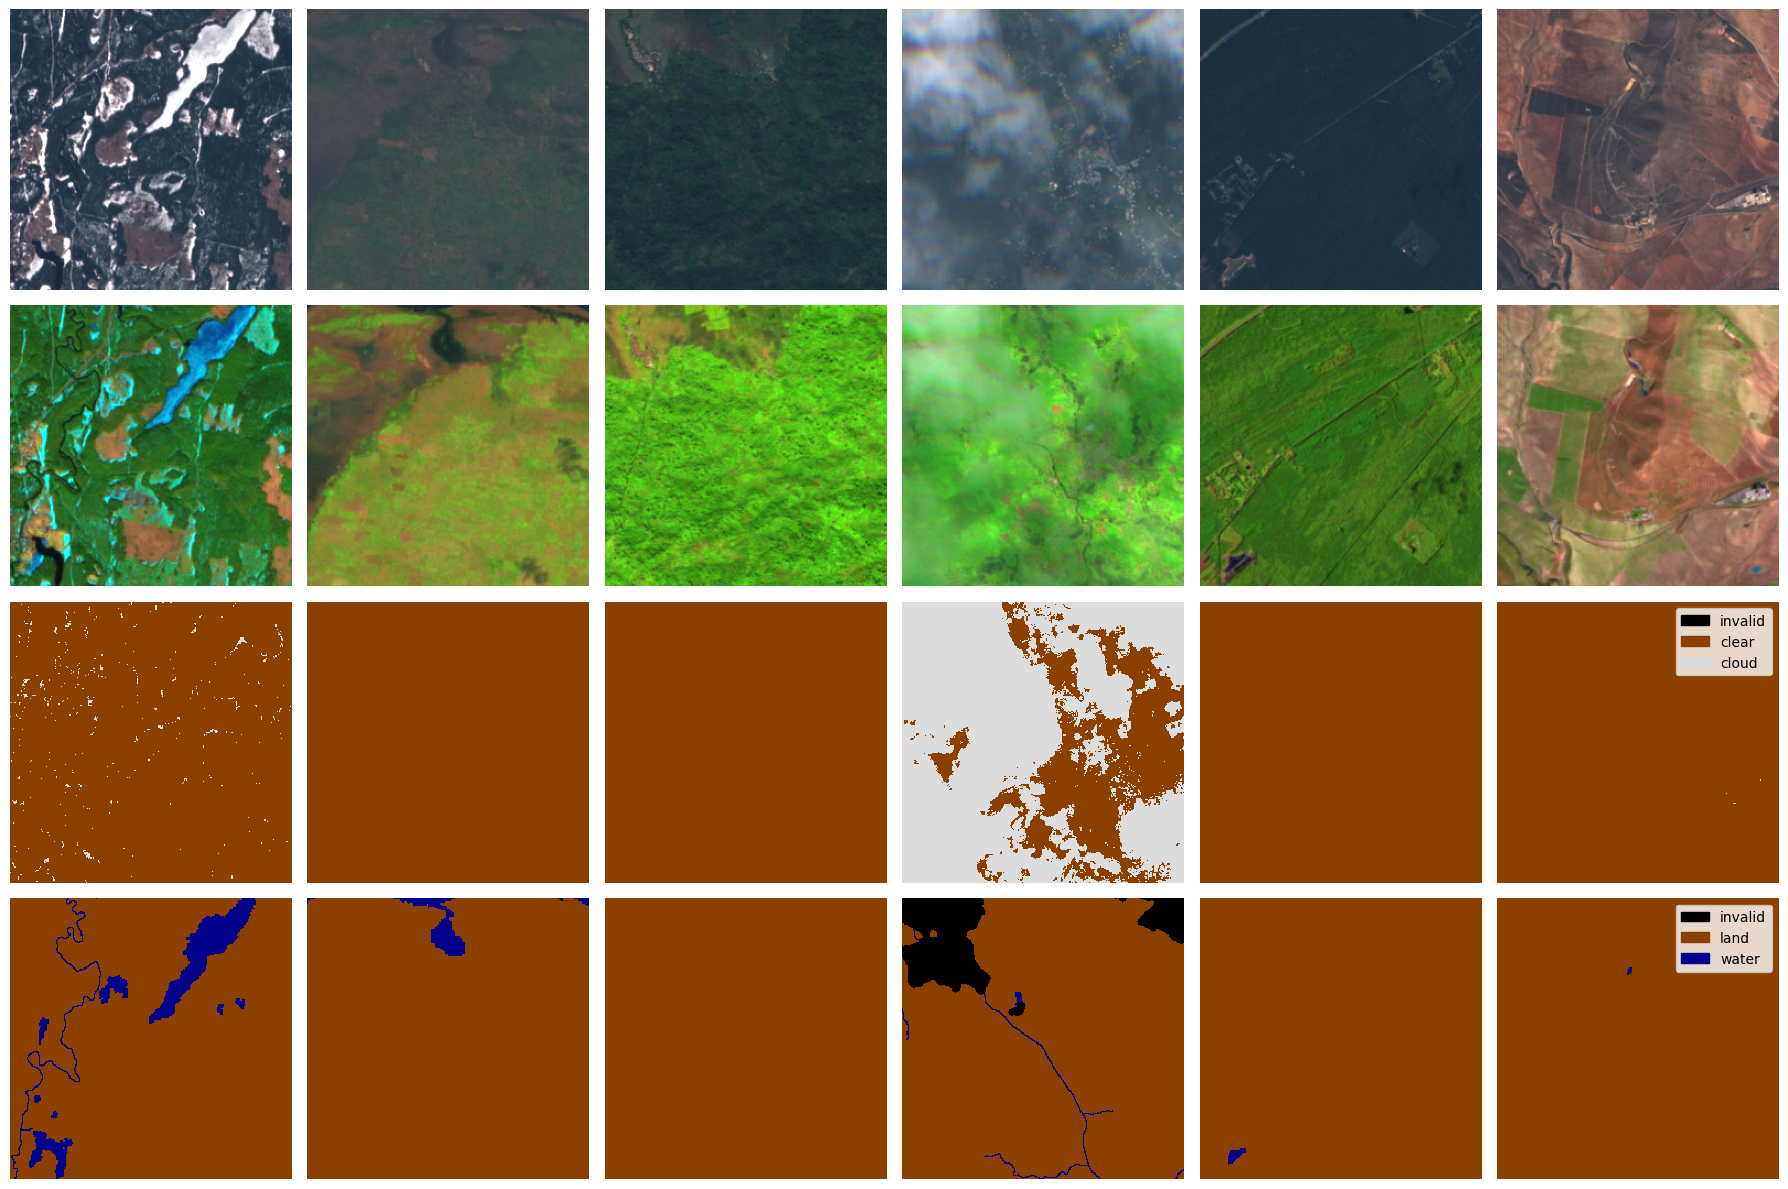

In [7]:
from ml4floods.models import worldfloods_model
import matplotlib.pyplot as plt
from ml4floods.data.worldfloods import configs
from ml4floods.visualization import plot_utils


n_images=6
fig, axs = plt.subplots(4,n_images, figsize=(18,12),tight_layout=True,sharex=True,sharey=True)
worldfloods_model.plot_batch(batch["image"][:n_images],axs=axs[0],max_clip_val=3500.)
worldfloods_model.plot_batch(batch["image"][:n_images],bands_show=["B11","B8", "B4"],
                             axs=axs[1],max_clip_val=4500.)

# worldfloods_model.plot_batch_output_v1(batch["mask"][:n_images, 0],axs=axs[2], show_axis=True)

cmap_preds_clouds, norm_preds_clouds, patches_preds_clouds = plot_utils.get_cmap_norm_colors(configs.COLORS_WORLDFLOODS_INVCLEARCLOUD,
                                                                        ["invalid","clear","cloud"])

for _i, (xi, ax) in enumerate(zip(batch["mask"][:n_images,0], axs[2])):
    ax.imshow(xi, cmap=cmap_preds_clouds, norm=norm_preds_clouds,
              interpolation='nearest')
    ax.axis("off")

    if _i == (len(batch["image"][:n_images,0])-1):
        ax.legend(handles=patches_preds_clouds,
                  loc='upper right')


cmap_preds_water, norm_preds_water, patches_preds_water = plot_utils.get_cmap_norm_colors(configs.COLORS_WORLDFLOODS_INVLANDWATER,
                                                                        ["invalid","land","water"])

for _i, (xi, ax) in enumerate(zip(batch["mask"][:n_images,1], axs[3])):
    ax.imshow(xi, cmap=cmap_preds_water, norm=norm_preds_water,
              interpolation='nearest')
    ax.axis("off")

    if _i == (len(batch["mask"][:n_images,0])-1):
        ax.legend(handles=patches_preds_water,
                  loc='upper right')


## Licence
The ML4Floods package is published under a [GNU Lesser GPL v3 licence](https://www.gnu.org/licenses/lgpl-3.0.en.html)

The *WorldFloods* database and all pre-trained models are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt). For using the models in comercial pipelines written consent by the authors must be provided.

The Ml4Floods notebooks and docs are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt).

 If you find this work useful please cite:
```
@article{portales-julia_global_2023,
	title = {Global flood extent segmentation in optical satellite images},
	volume = {13},
	issn = {2045-2322},
	doi = {10.1038/s41598-023-47595-7},
	number = {1},
	urldate = {2023-11-30},
	journal = {Scientific Reports},
	author = {Portalés-Julià, Enrique and Mateo-García, Gonzalo and Purcell, Cormac and Gómez-Chova, Luis},
	month = nov,
	year = {2023},
	pages = {20316},
}
```

## Acknowledgments

This research has been supported by the DEEPCLOUD project (PID2019-109026RB-I00) funded by the Spanish Ministry of Science and Innovation (MCIN/AEI/10.13039/501100011033) and the European Union (NextGenerationEU).

<img width="300" title="DEEPCLOUD project (PID2019-109026RB-I00, University of Valencia) funded by MCIN/AEI/10.13039/501100011033." alt="DEEPCLOUD project (PID2019-109026RB-I00, University of Valencia) funded by MCIN/AEI/10.13039/501100011033." src="https://www.uv.es/chovago/logos/logoMICIN.jpg">